In [1]:
import PyPDF2
import stanfordnlp
import pickle
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import *
import random
import matplotlib.pyplot as plt

In [2]:
# model and tokenizer class for the concrete downstream task: BertModel, BertForQuestionAnswering, etc.
model_class = BertModel
tokenizer_class = BertTokenizer

# weights to use
pretrained_weights = 'scibert-scivocab-uncased'

# initialize models and tokenizer
bert_model = model_class.from_pretrained(pretrained_weights)
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

# download english models that the neural pipeline will uses
#stanfordnlp.download('en')

# setting a default neural pipeline for english
# Now nlp is a function that receives a string as input and returns an nlp object
MODELS_DIR = '/Users/sergicastellasape/Repos/zeta-alpha/stanfordnlp_resources'
nlp = stanfordnlp.Pipeline(models_dir=MODELS_DIR)

dataset_path = '/Users/sergicastellasape/Repos/zeta-alpha/datasets/dummy/'

def get_attention_vec(model_output):
    final_attention, final_state, hidden_states_tup, hidden_attentions_tup = model_output
    hidden_attentions = torch.cat(hidden_attentions_tup, dim=0) # stacking along batch dim
    layers, heads, seq_length, _ = hidden_attentions.size()
    attention_vec = hidden_attentions.view(layers*heads, seq_length, seq_length).transpose(0,2)
    return attention_vec.reshape(seq_length**2, layers*heads)

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/Users/sergicastellasape/Repos/zeta-alpha/stanfordnlp_resources/en_ewt_models/en_ewt_tokenizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/Users/sergicastellasape/Repos/zeta-alpha/stanfordnlp_resources/en_ewt_models/en_ewt_tagger.pt', 'pretrain_path': '/Users/sergicastellasape/Repos/zeta-alpha/stanfordnlp_resources/en_ewt_models/en_ewt.pretrain.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/Users/sergicastellasape/Repos/zeta-alpha/stanfordnlp_resources/en_ewt_models/en_ewt_lemmatizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
---
Loading: depparse
With settings: 
{'model_path': '/Users/sergicastellasa

In [16]:
input_sequence_list = [
    "Sometimes, all you need to do is completely make an ass of yourself and laugh it off to realise that life isn’t so bad after all.",
    "I was very proud of my nickname throughout high school but today- I couldn’t be any different to what my nickname was.",
    "The shooter says goodbye to his love.",
    "A glittering gem is not enough.",
    "I think I will buy the red car, or I will lease the blue one.",
    "If you like tuna and tomato sauce- try combining the two. It’s really not as bad as it sounds.",
    "If you like tuna and tomato sauce- try combining the two. It’s really not as bad as it sounds.",
    "She did not cheat on the test, for it was not the right thing to do.",
    "She folded her handkerchief neatly.",
    "Someone I know recently combined Maple Syrup & buttered Popcorn thinking it would taste like caramel popcorn. It didn’t and they don’t recommend anyone else do it either.",
    "My Mum tries to be cool by saying that she likes all the same things that I do.",
    "Joe made the sugar cookies; Susan decorated them.",
    "I am happy to take your donation; any amount will be greatly appreciated.",
    "I would have gotten the promotion, but my attendance wasn’t good enough.",
    "He turned in the research paper on Friday; otherwise, he would have not passed the class."
]

for idx, input_sequence in enumerate(input_sequence_list):
    # generate input in the proper data format
    input_ids = tokenizer.encode(input_sequence)
    input_tensor = torch.tensor([input_ids])

    # RUN THE MODEL FORWARD
    # the model output consists of a tuple with 4 components which are the following:
    # Final attention: tensor [batch, seq_length, embedding_size]
    # Final state: tensor.Size[batch, embedding_size]
    # hidden_states_tuple: tuple of length # layers + 1 (it probably inclues the input)
        # hidden_states_tuple[i]: tensor.Size(batch, seq_length, embedding_size)
    # hidden_attentions_tuple: tuple of length # layers
        # hidden_attentions_tuple[i]: tensor.Size(batch, #heads, seq_length, seq_length)
    
    model_output = bert_model(input_tensor)
    
    # generate the stanford nlp object that stores relationships, etc.
    nlp_obj = nlp(input_sequence)
    
    # save in folder for future experiments
    with open(os.path.join(dataset_path, f'scibert_outputs/model_output_{idx}.p'), 'wb' ) as model_file:
        pickle.dump(model_output, model_file)
        
    with open(os.path.join(dataset_path, f'nlp_objects/nlp_obj_{idx}*.p'), 'wb') as nlp_file:
        pickle.dump(nlp_obj, nlp_file)
        

../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATen/native/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
../aten/src/ATe

In [3]:
def attention_dataset_loader(dataset_path, shuffle=True):
    
    model_outputs_list = glob.glob(f'{dataset_path}/scibert_outputs/model_output_*.p')
    nlp_objects_list = glob.glob(f'{dataset_path}/nlp_objects/nlp_obj_*.p')
    data_list = list(zip(model_outputs_list, nlp_objects_list))
    
    attention_dataset = torch.empty((0, 144))
    
    for data in data_list:
        with open(data[0], 'rb') as f:
            model_output = pickle.load(f)
        
        final_attention, final_state, hidden_states_tup, hidden_attentions_tup = model_output
        attention_vec = get_attention_vec(model_output)
        attention_dataset = torch.cat([attention_dataset, attention_vec] , dim=0)

        with open(data[1], 'rb') as f:
            nlp_obj = pickle.load(f)
    if shuffle:
        idx = torch.randperm(attention_dataset.size(0)) 
        return attention_dataset[idx, :]
    else:
        return attention_dataset

In [4]:
data = attention_dataset_loader(dataset_path, shuffle=True)

train_ratio, test_ratio = 0.8, 0.2
N = int(0.8 * data.size(0))
train_data = data[0:N, :]
test_data = data[N:, :]

batch_size = 32
train_data_batch = list(train_data.split(batch_size, dim=0))
test_data_batch = list(test_data.split(batch_size, dim=0))

#########Random sample and reconstruction###########
Train Epoch: 1 [0/223 (0%)]	Loss: 14.673180
Train Epoch: 1 [20/223 (9%)]	Loss: 10.280327
Train Epoch: 1 [40/223 (18%)]	Loss: 8.800252
Train Epoch: 1 [60/223 (27%)]	Loss: 5.110516
Train Epoch: 1 [80/223 (36%)]	Loss: 5.264652
Train Epoch: 1 [100/223 (45%)]	Loss: 3.473910
Train Epoch: 1 [120/223 (54%)]	Loss: 3.994978
Train Epoch: 1 [140/223 (63%)]	Loss: 3.568108
Train Epoch: 1 [160/223 (72%)]	Loss: 2.884207
Train Epoch: 1 [180/223 (81%)]	Loss: 4.414081
Train Epoch: 1 [200/223 (90%)]	Loss: 3.531755
Train Epoch: 1 [220/223 (99%)]	Loss: 2.825806
====> Epoch: 1 Average loss: 1172.8727
====> Test set loss: 718.9626
#########Random sample and reconstruction###########
Train Epoch: 2 [0/223 (0%)]	Loss: 3.275936
Train Epoch: 2 [20/223 (9%)]	Loss: 2.307310
Train Epoch: 2 [40/223 (18%)]	Loss: 3.878583
Train Epoch: 2 [60/223 (27%)]	Loss: 3.242848
Train Epoch: 2 [80/223 (36%)]	Loss: 3.689768
Train Epoch: 2 [100/223 (45%)]	Loss: 2.622594
Train Epoch

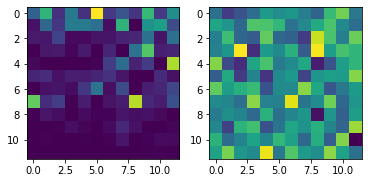

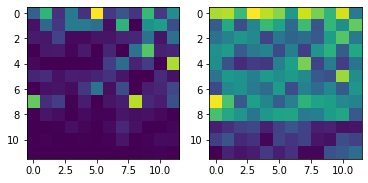

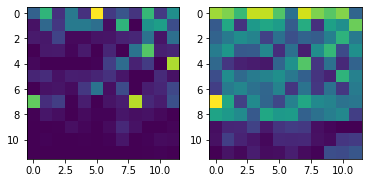

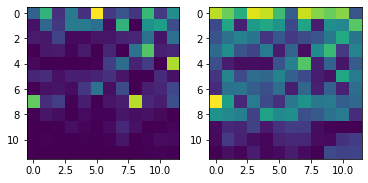

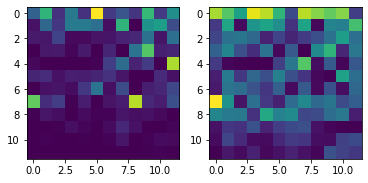

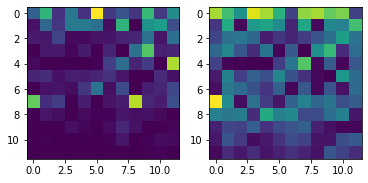

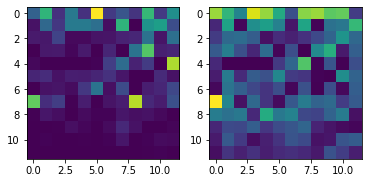

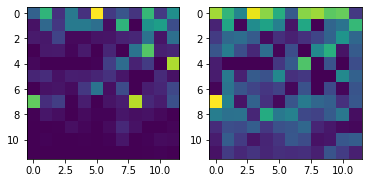

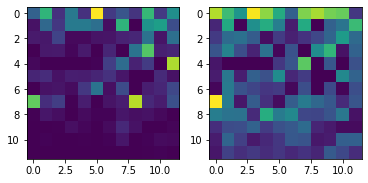

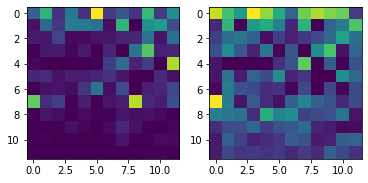

In [170]:
#device = torch.device("cuda" if args.cuda else "cpu")

class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedding_size):
        super(VAE, self).__init__()
        self.input_size = input_size
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, embedding_size)
        self.fc22 = nn.Linear(hidden_size, embedding_size)
        self.fc3 = nn.Linear(embedding_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_size))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch, DATA=train_data_batch):
    model.train()
    train_loss = 0
    for batch_idx, att_tensor in enumerate(train_data_batch):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(att_tensor)
        target = att_tensor.detach()
        loss = loss_function(recon_batch, target, mu, logvar)
        loss.backward(retain_graph=True)
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx , len(train_data_batch),
                100. * batch_idx / len(train_data_batch),
                loss.item() / len(train_data_batch)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_data_batch)))


def test(epoch, DATA=test_data_batch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, att_tensor in enumerate(test_data_batch):
            #data = data.to(device)
            recon_batch, mu, logvar = model(att_tensor)
            test_loss += loss_function(recon_batch, att_tensor.detach(), mu, logvar).item()

    test_loss /= len(test_data_batch)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    
def sample(random_sample=True, deterministic_embedding=False, sample=0, idx=0):
    print("#########Random sample and reconstruction###########")
    model.eval()
    with torch.no_grad():
        # get a random attention vector to sample from
        if random_sample:
            att_tensor = random.choice(test_data_batch)
            idx = random.randint(0, att_tensor.size()[0] - 1)
            vec = att_tensor[idx, :]
        else:
            att_tensor = test_data_batch[sample]
            vec = att_tensor[idx, :]
        
        if deterministic_embedding:
            # try to sample deterministically for more consistent results
            mu, logvar = model.encode(vec)
            recon_img = model.decode(mu)
        else:
            recon_img, _, _ = model(vec)
        
        img = vec.view(12, 12).detach().numpy()
        recon_img = recon_img.view(12, 12).detach().numpy()
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(img)
        axs[1].imshow(recon_img)
        plt.draw()
            
epochs = 10
device = torch.device('cpu')
model = VAE(144, 100, 144, 2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
log_interval = 20

if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        sample(random_sample=False, deterministic_embedding=True, sample=2, idx=2)
        train(epoch)
        test(epoch)
        

In [115]:
model_embedding100_KL02 = model

#########Random sample and reconstruction###########


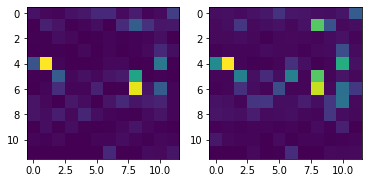

In [176]:
# Interesting results after 50 epochs, embedding size of 2 and 
# sample=3 idx=2 is interesting, very stable
sample(random_sample=False, deterministic_embedding=False, sample=3, idx=2)